In [1]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sbi.inference import NPE, simulate_for_sbi
from sbi import analysis
import torch

from sbi import utils as sbi_utils
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

/home/sam/miniconda3/envs/pandora/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configuration
num_samples = 100
t_max = 20
num_timesteps = 64
x_data = np.abs(np.cumsum(np.random.rand(num_samples, num_timesteps, 1) - 0.5, axis=1))
t_data = np.linspace(0, t_max, num_timesteps)

In [5]:
def get_param_labels_and_values(sample, num_masses):
    """
    Given a sample tensor and number of masses, returns a list of parameter values and their labels.
    Assumes sample shape is (1, 3*num_masses) or (3*num_masses,).
    """
    sample = sample.flatten()
    m = sample[:num_masses].tolist()
    k = sample[num_masses:2*num_masses].tolist()
    b = sample[2*num_masses:3*num_masses].tolist()
    params = m + k + b
    labels = [f"m{i}" for i in range(num_masses)] + \
             [f"k{i}" for i in range(num_masses)] + \
             [f"b{i}" for i in range(num_masses)]
    return params, labels

def get_param_labels_and_values(sample, num_masses):
    """
    Given a sample tensor and number of masses, returns a list of parameter values and their labels.
    Assumes sample shape is (1, 3*num_masses) or (3*num_masses,).
    """
    sample = sample.flatten()
    m = sample[:num_masses].tolist()
    k = sample[num_masses:2*num_masses].tolist()
    b = sample[2*num_masses:3*num_masses].tolist()
    params = m + k + b
    labels = [f"m{i}" for i in range(num_masses)] + \
             [f"k{i}" for i in range(num_masses)] + \
             [f"b{i}" for i in range(num_masses)]
    return params, labels

In [6]:
# [WALL]--(k0,b0)--[m0]--(k1,b1)--[m1]--(k2,b2)--[m2]

# Define system of equations
def multi_mass_spring_damper(y, t, m, k, b, F_ext=None):
    """
    y: concatenated [x0, x1, ..., xn, v0, v1, ..., vn]
    m, k, b: arrays of length n
    F_ext: optional external force per mass at time t
    """
    n = len(m)
    x = y[:n]
    v = y[n:]
    
    dxdt = v
    dvdt = np.zeros(n)

    for i in range(n):
        # External force
        F = 0
        if F_ext is not None:
            F = np.interp(t, t_data, F_ext[i])

        # F = np.interp(t, t_data, x_data[0, :, 0])

        # Spring-damper forces from neighbors
        force = 0

        # Left spring/damper: wall or previous mass
        if i == 0: 
         force += -k[0] * x[0] - b[0] * v[0]  # connected to wall
        else:
            force += -k[i] * (x[i] - x[i-1]) - b[i] * (v[i] - v[i-1])

        # Right spring/damper: next mass if not last
        if i < n - 1:
            force += -k[i+1] * (x[i] - x[i+1]) - b[i+1] * (v[i] - v[i+1])

        dvdt[i] = (F + force) / m[i]

    return np.concatenate([dxdt, dvdt])


def multi_msd_simulator(params, F_ext=None):
    """
    params: [m0, m1, ..., k0, k1, ..., b0, b1, ...]
    """
    m = np.array(params[:num_masses])
    k = np.array(params[num_masses:2*num_masses])
    b = np.array(params[2*num_masses:3*num_masses])

    t = np.linspace(0, 10, num_timesteps)
    y0 = np.zeros(2 * num_masses)  # Initial positions and velocities

    sol = odeint(multi_mass_spring_damper, y0, t, args=(m, k, b, F_ext))

    x = sol[:, :num_masses]
    v = sol[:, num_masses:]

    return extract_summary_statistics_multimass(t, x, v)


def extract_summary_statistics_multimass(t, x, v):
    num_masses = x.shape[1]

    # Compute stats per mass
    stats = []
    for i in range(num_masses):
        stats.extend(extract_summary_statistics(t, x[:, i], v[:, i]))

    return np.array(stats)


def extract_summary_statistics(t, x, v):
    steady_state = x[-1]

    # Settling time
    settling_idx = np.where(np.abs(x - steady_state) <= 0.05 * np.abs(steady_state))[0]
    settling_time = t[settling_idx[0]] if len(settling_idx) > 0 else np.nan

    # Rise time (time to go from 10% to 90% of final value)
    try:
        rise_start = np.where(x >= 0.1 * steady_state)[0][0]
        rise_end = np.where(x >= 0.9 * steady_state)[0][0]
        rise_time = t[rise_end] - t[rise_start]
    except IndexError:
        rise_time = np.nan

    # Peak overshoot
    peak_overshoot = (np.max(x) - steady_state) / steady_state if steady_state != 0 else np.nan

    # Final position and velocity
    final_position = x[-1]
    final_velocity = v[-1]

    # Mean and variance of position and velocity (to handle randomness)
    mean_position = np.mean(x)
    var_position = np.var(x)
    mean_velocity = np.mean(v)
    var_velocity = np.var(v)
    energy = np.sum(x**2)
    max_rate_of_change = np.max(np.diff(x) / np.diff(t))

    # Combine all summary stats into a single vector
    summary_stats = np.array([
        settling_time, rise_time, peak_overshoot,
        final_position, final_velocity,
        mean_position, var_position,
        mean_velocity, var_velocity,
        energy, max_rate_of_change
    ])
    
    # Handle any NaNs with a fallback value (e.g., -1 or zero)
    summary_stats = np.nan_to_num(summary_stats, nan=-1)

    return summary_stats

def generate_deterministic_force(timesteps, seed=42, smoothing=2.0):
    rng = np.random.default_rng(seed)
    raw = rng.random(timesteps) - 0.5
    force = np.cumsum(raw)
    force = gaussian_filter1d(force, sigma=smoothing)
    return np.abs(force)

def simulator(params):
    # # Generate new force profile per sample
    
    # sample_idx = 0
    # F_shared = x_data[sample_idx, :, 0]
    # F_ext = np.tile(F_shared, (num_masses, 1))

    # Fixed random walk profile
    F_signal = generate_deterministic_force(num_timesteps)
    F_ext = np.tile(F_signal, (num_masses, 1)) 

    # F_ext = np.abs(np.cumsum(np.random.rand(num_masses, num_timesteps) - 0.5, axis=1))
    return multi_msd_simulator(params, F_ext=F_ext)

/tmp/ipykernel_6513/4247787527.py:47: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  m = np.array(params[:num_masses])
/tmp/ipykernel_6513/4247787527.py:48: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  k = np.array(params[num_masses:2*num_masses])
/tmp/ipykernel_6513/4247787527.py:49: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the 


Running simulation for 2 masses


100%|██████████| 20000/20000 [03:48<00:00, 87.63it/s] 


Simulation time: 228.28 seconds
 Neural network successfully converged after 359 epochs.Training time: 341.73 seconds


Drawing 10000 posterior samples: 10206it [00:00, 90861.76it/s]            

Inference time: 0.11 seconds

Parameter  True       Inferred   % Error    Abs Error 
-------------------------------------------------------
m0         1.1902     4.2933     260.72     3.1031    
m1         7.9612     6.6437     16.55      1.3175    
k0         6.3069     6.2540     0.84       0.0529    
k1         9.7102     9.5991     1.14       0.1111    
b0         4.2181     4.5264     7.31       0.3083    
b1         5.6538     5.7360     1.45       0.0821    
-------------------------------------------------------
MSE: 1.913688

Generating pairplot for 2 masses...



Total time for 2 masses: 570.54 seconds

Running simulation for 3 masses


100%|██████████| 20000/20000 [05:28<00:00, 60.83it/s]


Simulation time: 328.81 seconds
 Neural network successfully converged after 459 epochs.Training time: 443.69 seconds


Drawing 10000 posterior samples: 10312it [00:00, 67255.38it/s]                          


Inference time: 0.16 seconds

Parameter  True       Inferred   % Error    Abs Error 
-------------------------------------------------------
m0         2.1031     3.6276     72.49      1.5245    
m1         6.3159     5.7520     8.93       0.5639    
m2         4.0770     4.3639     7.04       0.2869    
k0         9.6698     9.7012     0.32       0.0314    
k1         4.6605     4.6649     0.09       0.0044    
k2         5.4191     5.6282     3.86       0.2091    
b0         5.1106     5.0630     0.93       0.0477    
b1         8.1544     8.0721     1.01       0.0823    
b2         8.0811     7.1679     11.30      0.9132    
-------------------------------------------------------
MSE: 0.401341

Generating pairplot for 3 masses...

Total time for 3 masses: 773.42 seconds

Running simulation for 4 masses


100%|██████████| 20000/20000 [07:46<00:00, 42.85it/s]


Simulation time: 466.74 seconds
 Neural network successfully converged after 327 epochs.Training time: 311.21 seconds


Drawing 10000 posterior samples: 10175it [00:01, 6557.53it/s]                          


Inference time: 1.55 seconds

Parameter  True       Inferred   % Error    Abs Error 
-------------------------------------------------------
m0         1.1222     4.1940     273.74     3.0719    
m1         0.3828     1.0842     183.22     0.7014    
m2         2.7983     4.3105     54.04      1.5122    
m3         9.6273     8.5442     11.25      1.0831    
k0         7.8041     8.4842     8.72       0.6802    
k1         7.8979     7.2556     8.13       0.6423    
k2         0.3268     0.4104     25.57      0.0836    
k3         9.8823     9.3350     5.54       0.5473    
b0         9.3626     4.8049     48.68      4.5577    
b1         0.1917     2.8098     1365.80    2.6181    
b2         2.2225     1.9374     12.83      0.2851    
b3         3.0583     7.6936     151.57     4.6353    
-------------------------------------------------------
MSE: 5.313739

Generating pairplot for 4 masses...

Total time for 4 masses: 780.69 seconds


SUMMARY OF ALL RUNS

Results for 2 masses:
Total 

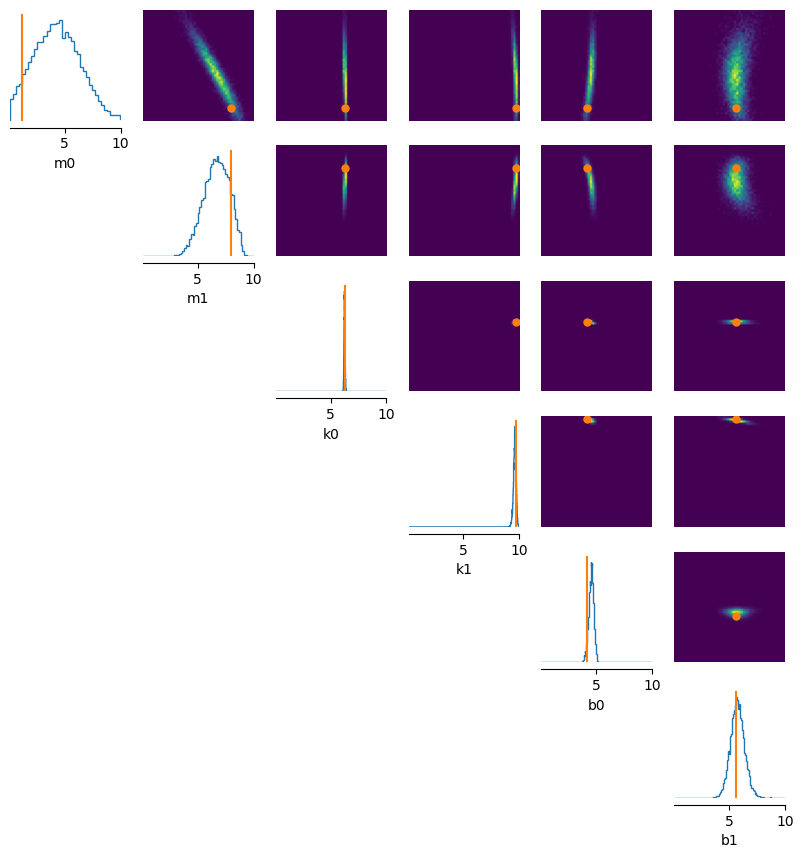

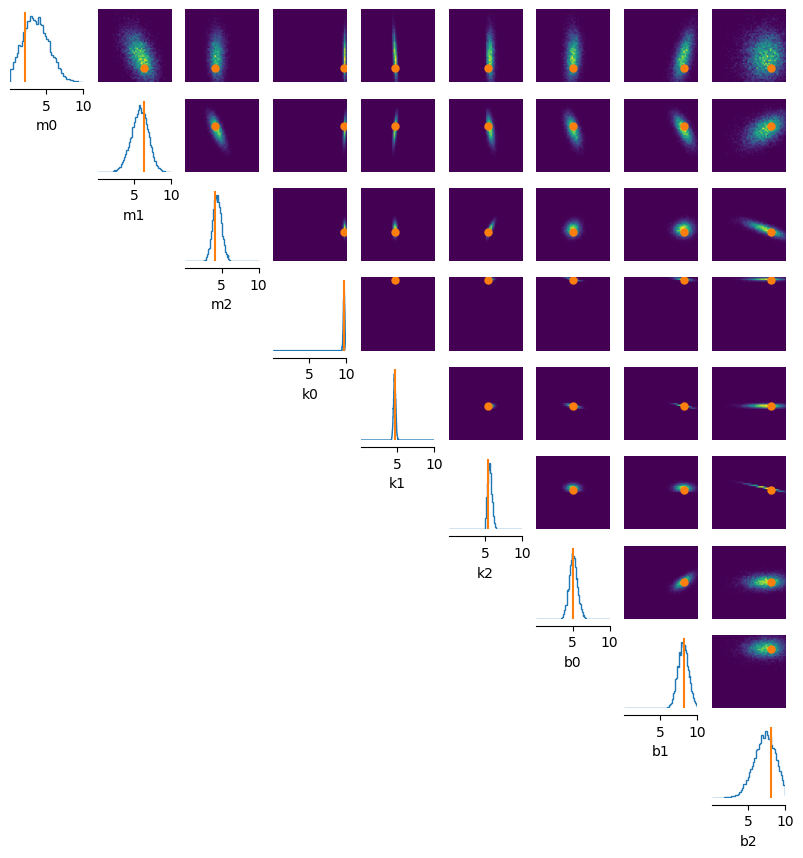

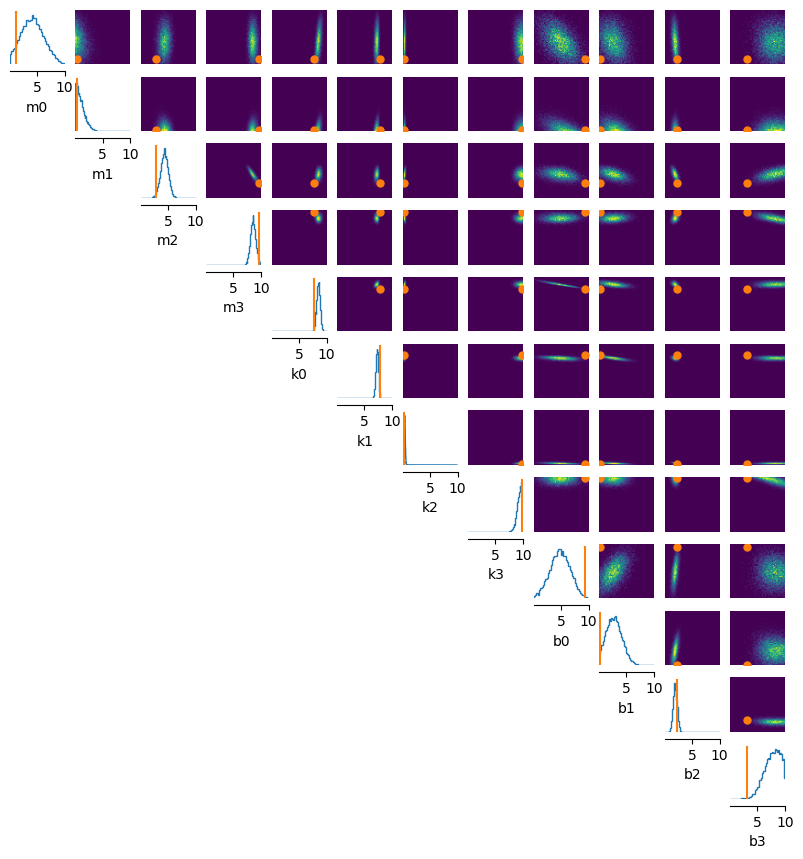

In [7]:
import time

# Prior distribution for (m, k, b) — for different number of masses

results = []

for num_masses in range(2, 5):  # 2, 3, 4 masses
    start_time = time.time()
    print(f"\n{'='*60}")
    print(f"Running simulation for {num_masses} masses")
    print(f"{'='*60}")
    
    num_simulations = 20000
    num_params = 3 * num_masses 

    # Set up the prior
    prior = sbi_utils.BoxUniform(
        low=torch.tensor([0.1] * num_params),
        high=torch.tensor([10.0] * num_params)
    )

    prior, num_parameters, prior_returns_numpy = process_prior(prior)

    simulator_wrapper = process_simulator(
        simulator,
        prior,
        prior_returns_numpy
    )

    check_sbi_inputs(simulator_wrapper, prior)

    # Create inference object
    inference = NPE(prior)

    # Simulation phase
    sim_start_time = time.time()
    theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=num_simulations)
    sim_time = time.time() - sim_start_time
    print(f"Simulation time: {sim_time:.2f} seconds")

    # Training phase
    train_start_time = time.time()
    density_estimator = inference.append_simulations(theta, x).train()
    train_time = time.time() - train_start_time
    print(f"Training time: {train_time:.2f} seconds")

    # Build posterior
    posterior = inference.build_posterior(density_estimator)

    # Generate a sample from the prior for testing
    sample = prior.sample((1,))
    observed_data = simulator(sample.numpy()[0])
    observed_data = torch.tensor(observed_data, dtype=torch.float32)

    # Infer parameters
    inference_start_time = time.time()
    samples = posterior.sample((10000,), x=observed_data)
    inference_time = time.time() - inference_start_time
    print(f"Inference time: {inference_time:.2f} seconds")

    # Calculate mean of samples for each parameter
    mean_samples = torch.mean(samples, dim=0)

    # Print comparison between true and inferred parameters
    true_params, labels = get_param_labels_and_values(sample, num_masses)
    inferred_params, _ = get_param_labels_and_values(mean_samples, num_masses)

    # Calculate MSE and percentage errors
    mse = 0
    print(f"\n{'Parameter':<10} {'True':<10} {'Inferred':<10} {'% Error':<10} {'Abs Error':<10}")
    print("-" * 55)

    param_errors = []
    for i, label in enumerate(labels):
        pct_error = abs(true_params[i] - inferred_params[i]) / true_params[i] * 100
        abs_error = abs(true_params[i] - inferred_params[i])
        mse += (true_params[i] - inferred_params[i]) ** 2
        param_errors.append((label, true_params[i], inferred_params[i], pct_error, abs_error))
        print(f"{label:<10} {true_params[i]:<10.4f} {inferred_params[i]:<10.4f} {pct_error:<10.2f} {abs_error:<10.4f}")

    mse /= len(true_params)
    print("-" * 55)
    print(f"MSE: {mse:.6f}")
    
    # Create sample point from true parameters for plotting
    sample_point = sample.numpy()[0]

    # Generate pairplot
    print(f"\nGenerating pairplot for {num_masses} masses...")
    fig, ax = analysis.pairplot(
        samples,
        points=sample,
        labels=labels,
        limits=[[float(l), float(h)] for l, h in zip(prior.base_dist.low.numpy(), prior.base_dist.high.numpy())]
    )
    
    total_time = time.time() - start_time
    print(f"\nTotal time for {num_masses} masses: {total_time:.2f} seconds")
    
    # Store results for this run
    results.append({
        'num_masses': num_masses,
        'simulation_time': sim_time,
        'training_time': train_time,
        'inference_time': inference_time,
        'total_time': total_time,
        'mse': mse,
        'param_errors': param_errors,
        'posterior': posterior
    })

# Print summary of all runs
print("\n\n" + "="*80)
print("SUMMARY OF ALL RUNS")
print("="*80)
for result in results:
    print(f"\nResults for {result['num_masses']} masses:")
    print(f"Total time: {result['total_time']:.2f} seconds")
    print(f"Simulation time: {result['simulation_time']:.2f} seconds")
    print(f"Training time: {result['training_time']:.2f} seconds")
    print(f"Inference time: {result['inference_time']:.2f} seconds")
    print(f"MSE: {result['mse']:.6f}")

In [8]:
import pickle
import os

# Create a directory to save the posteriors if it doesn't exist
save_dir = "saved_posteriors"
os.makedirs(save_dir, exist_ok=True)

# Save each posterior from the results list
for i, result in enumerate(results):
    num_masses = result['num_masses']
    posterior = result['posterior']
    
    # Define the filename
    filename = f"{save_dir}/posterior_masses_{num_masses}.pkl"
    
    # Save the posterior using pickle
    with open(filename, 'wb') as f:
        pickle.dump(posterior, f)
    
    print(f"Saved posterior for {num_masses} masses to {filename}")

# Example of how to load a posterior back
# with open(f"{save_dir}/posterior_masses_2.pkl", 'rb') as f:
#     loaded_posterior = pickle.load(f)

Saved posterior for 2 masses to saved_posteriors/posterior_masses_2.pkl
Saved posterior for 3 masses to saved_posteriors/posterior_masses_3.pkl
Saved posterior for 4 masses to saved_posteriors/posterior_masses_4.pkl


In [ ]:
import pickle
import os
import torch
import numpy as np
from sbi import analysis
from sbi.utils import BoxUniform

# Load saved posteriors and generate analysis for each one
import matplotlib.pyplot as plt

# Load saved posteriors
save_dir = "saved_posteriors-1"
posteriors = {}

# Get list of all pickle files in directory
posterior_files = [f for f in os.listdir(save_dir) if f.endswith('.pkl')]

# Load each posterior
for file in posterior_files:
    with open(os.path.join(save_dir, file), 'rb') as f:
        posterior = pickle.load(f)
        # Extract number of masses from filename
        num_masses = int(file.split('_')[-1].split('.')[0])
        posteriors[num_masses] = posterior

# Analysis for each posterior
analyzed_results = []

for num_masses, posterior in posteriors.items():
    print(f"\n{'='*60}")
    print(f"Analyzing posterior for {num_masses} masses")
    print(f"{'='*60}")
    
    # Set up the prior for this number of masses
    num_params = 3 * num_masses
    prior = BoxUniform(
        low=torch.tensor([0.1] * num_params),
        high=torch.tensor([10.0] * num_params)
    )
    
    # Sample from prior to generate "ground truth"
    sample = prior.sample((1,))
    
    # Run simulator with these parameters to get observation
    observed_data = simulator(sample.numpy()[0])
    observed_data = torch.tensor(observed_data, dtype=torch.float32)
    
    # Sample from posterior given this observation
    samples = posterior.sample((10000,), x=observed_data)
    
    # Calculate mean of samples for each parameter
    mean_samples = torch.mean(samples, dim=0)
    
    # Generate parameter labels
    def get_param_labels_and_values(sample, num_masses):
        sample = sample.flatten()
        m = sample[:num_masses].tolist()
        k = sample[num_masses:2*num_masses].tolist()
        b = sample[2*num_masses:3*num_masses].tolist()
        params = m + k + b
        labels = [f"m{i}" for i in range(num_masses)] + \
                 [f"k{i}" for i in range(num_masses)] + \
                 [f"b{i}" for i in range(num_masses)]
        return params, labels
    
    # Print comparison between true and inferred parameters
    true_params, labels = get_param_labels_and_values(sample, num_masses)
    inferred_params, _ = get_param_labels_and_values(mean_samples, num_masses)
    
    # Calculate MSE and percentage errors
    mse = 0
    print(f"\n{'Parameter':<10} {'True':<10} {'Inferred':<10} {'% Error':<10} {'Abs Error':<10}")
    print("-" * 55)
    
    param_errors = []
    for i, label in enumerate(labels):
        pct_error = abs(true_params[i] - inferred_params[i]) / true_params[i] * 100
        abs_error = abs(true_params[i] - inferred_params[i])
        mse += (true_params[i] - inferred_params[i]) ** 2
        param_errors.append((label, true_params[i], inferred_params[i], pct_error, abs_error))
        print(f"{label:<10} {true_params[i]:<10.4f} {inferred_params[i]:<10.4f} {pct_error:<10.2f} {abs_error:<10.4f}")
    
    mse /= len(true_params)
    print("-" * 55)
    print(f"MSE: {mse:.6f}")
    
    # Generate pairplot
    print(f"\nGenerating pairplot for {num_masses} masses...")
    fig, ax = analysis.pairplot(
        samples,
        points=sample,
        labels=labels,
        limits=[[float(l), float(h)] for l, h in zip(prior.base_dist.low.numpy(), prior.base_dist.high.numpy())]
    )
    plt.savefig(f"pairplot_masses_{num_masses}.png", dpi=300, bbox_inches='tight')
    plt.close(fig)
    
    # Store results
    analyzed_results.append({
        'num_masses': num_masses,
        'mse': mse,
        'param_errors': param_errors,
        'true_params': true_params,
        'inferred_params': inferred_params
    })

# Print summary of all analyses
print("\n\n" + "="*80)
print("SUMMARY OF ALL ANALYSES")
print("="*80)
for result in analyzed_results:
    print(f"\nResults for {result['num_masses']} masses:")
    print(f"MSE: {result['mse']:.6f}")
    print(f"Average percent error: {np.mean([err[3] for err in result['param_errors']]):.2f}%")
    print(f"Average absolute error: {np.mean([err[4] for err in result['param_errors']]):.4f}")


Analyzing posterior for 4 masses


Drawing 10000 posterior samples: 10100it [00:01, 6432.27it/s]                          



Parameter  True       Inferred   % Error    Abs Error 
-------------------------------------------------------
m0         1.0042     1.6840     67.69      0.6797    
m1         1.8371     2.6812     45.95      0.8441    
m2         2.2410     1.6635     25.77      0.5775    
m3         1.1357     0.9495     16.39      0.1862    
k0         9.4200     9.3858     0.36       0.0342    
k1         1.9180     1.9426     1.28       0.0246    
k2         4.0325     3.5231     12.63      0.5094    
k3         4.4640     4.4021     1.39       0.0619    
b0         1.1211     1.3838     23.43      0.2627    
b1         1.7039     1.6509     3.11       0.0530    
b2         5.0174     7.4769     49.02      2.4595    
b3         1.3332     2.4235     81.78      1.0903    
-------------------------------------------------------
MSE: 0.759791

Generating pairplot for 4 masses...

Analyzing posterior for 2 masses


Drawing 10000 posterior samples: 10135it [00:00, 81895.70it/s]                          


Parameter  True       Inferred   % Error    Abs Error 
-------------------------------------------------------
m0         0.9818     1.6553     68.60      0.6735    
m1         5.2939     4.9591     6.32       0.3348    
k0         9.0354     9.0403     0.05       0.0050    
k1         7.4238     7.3911     0.44       0.0327    
b0         9.1708     9.1555     0.17       0.0153    
b1         6.4302     6.5119     1.27       0.0816    
-------------------------------------------------------
MSE: 0.095608

Generating pairplot for 2 masses...



Analyzing posterior for 3 masses


Drawing 10000 posterior samples: 10496it [00:00, 54020.57it/s]                          



Parameter  True       Inferred   % Error    Abs Error 
-------------------------------------------------------
m0         6.1188     6.2386     1.96       0.1198    
m1         8.1846     7.4708     8.72       0.7138    
m2         3.3393     3.6056     7.97       0.2663    
k0         5.7560     5.7117     0.77       0.0443    
k1         1.0562     0.9661     8.52       0.0900    
k2         1.8624     1.8873     1.34       0.0250    
b0         7.8227     8.1695     4.43       0.3468    
b1         8.3382     8.7375     4.79       0.3993    
b2         5.2288     4.9469     5.39       0.2819    
-------------------------------------------------------
MSE: 0.107184

Generating pairplot for 3 masses...


SUMMARY OF ALL ANALYSES

Results for 4 masses:
MSE: 0.759791
Average percent error: 27.40%
Average absolute error: 0.5653

Results for 2 masses:
MSE: 0.095608
Average percent error: 12.81%
Average absolute error: 0.1905

Results for 3 masses:
MSE: 0.107184
Average percent error: 4.88

/tmp/ipykernel_38101/4247787527.py:47: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  m = np.array(params[:num_masses])
/tmp/ipykernel_38101/4247787527.py:48: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  k = np.array(params[num_masses:2*num_masses])
/tmp/ipykernel_38101/4247787527.py:49: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see t

 Neural network successfully converged after 256 epochs.

Drawing 100000 posterior samples: 100099it [00:00, 253726.40it/s]                           


Parameter  True       Inferred   % Error    Abs Error 
-------------------------------------------------------
m0         6.2096     5.9718     3.83       0.2378    
k0         6.4789     6.2564     3.43       0.2225    
b0         3.3579     3.6864     9.78       0.3285    
-------------------------------------------------------
MSE: 0.071347


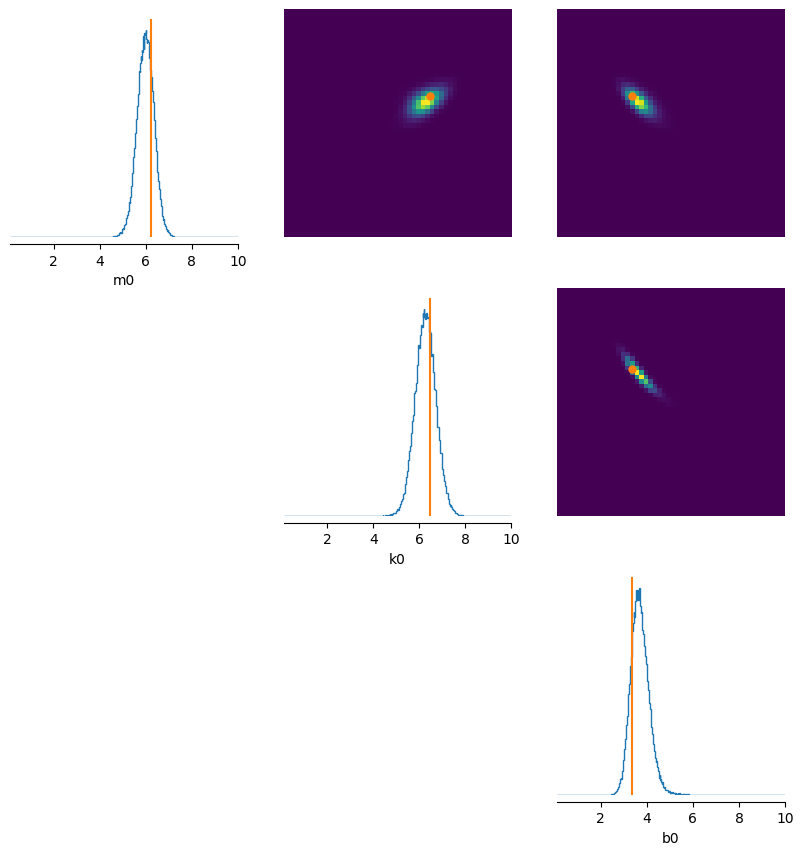

In [30]:
# Prior distribution for (m, k, b) — assuming you know rough ranges
num_masses = 1
num_simulations = 100

num_params = 3 * num_masses 

prior = sbi_utils.BoxUniform(
    low=torch.tensor([0.1] * num_params),
    high=torch.tensor([10.0] * num_params)
)

prior, num_parameters, prior_returns_numpy = process_prior(prior)

simulator_wrapper = process_simulator(
    simulator,
    prior,
    prior_returns_numpy
)

check_sbi_inputs(simulator_wrapper, prior)

# Create inference object
inference = NPE(prior)

theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=num_simulations)

# Train the inference network
density_estimator = inference.append_simulations(theta, x).train()

# Build posterior
posterior = inference.build_posterior(density_estimator)

def get_param_labels_and_values(sample, num_masses):
    """
    Given a sample tensor and number of masses, returns a list of parameter values and their labels.
    Assumes sample shape is (1, 3*num_masses) or (3*num_masses,).
    """
    sample = sample.flatten()
    m = sample[:num_masses].tolist()
    k = sample[num_masses:2*num_masses].tolist()
    b = sample[2*num_masses:3*num_masses].tolist()
    params = m + k + b
    labels = [f"m{i}" for i in range(num_masses)] + \
             [f"k{i}" for i in range(num_masses)] + \
             [f"b{i}" for i in range(num_masses)]
    return params, labels

def get_param_labels_and_values(sample, num_masses):
    """
    Given a sample tensor and number of masses, returns a list of parameter values and their labels.
    Assumes sample shape is (1, 3*num_masses) or (3*num_masses,).
    """
    sample = sample.flatten()
    m = sample[:num_masses].tolist()
    k = sample[num_masses:2*num_masses].tolist()
    b = sample[2*num_masses:3*num_masses].tolist()
    params = m + k + b
    labels = [f"m{i}" for i in range(num_masses)] + \
             [f"k{i}" for i in range(num_masses)] + \
             [f"b{i}" for i in range(num_masses)]
    return params, labels

sample = prior.sample((1,))
observed_data = simulator(sample.numpy()[0])
observed_data = torch.tensor(observed_data, dtype=torch.float32)

# Infer parameters
samples = posterior.sample((100000,), x=observed_data)

# Calculate mean of samples for each parameter
mean_samples = torch.mean(samples, dim=0)

# Print comparison between true and inferred parameters
true_params, labels = get_param_labels_and_values(sample, num_masses)
inferred_params, _ = get_param_labels_and_values(mean_samples, num_masses)

# Calculate MSE and percentage errors
mse = 0
print(f"{'Parameter':<10} {'True':<10} {'Inferred':<10} {'% Error':<10} {'Abs Error':<10}")
print("-" * 55)

for i, label in enumerate(labels):
    pct_error = abs(true_params[i] - inferred_params[i]) / true_params[i] * 100
    abs_error = abs(true_params[i] - inferred_params[i])
    mse += (true_params[i] - inferred_params[i]) ** 2
    
    print(f"{label:<10} {true_params[i]:<10.4f} {inferred_params[i]:<10.4f} {pct_error:<10.2f} {abs_error:<10.4f}")

mse /= len(true_params)
print("-" * 55)
print(f"MSE: {mse:.6f}")

# Create sample point from true parameters for plotting
sample_point = sample.numpy()[0]

fig, ax = analysis.pairplot(
    samples,
    points=sample,
    labels=labels,
    limits=[[float(l), float(h)] for l, h in zip(prior.base_dist.low.numpy(), prior.base_dist.high.numpy())]
)